In [2]:
# importing the necessary libraries
import re
import string
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus.reader.wordnet import NOUN, VERB, ADJ, ADV
from nltk.corpus import brown, stopwords
from nltk.cluster.util import cosine_distance
from operator import itemgetter
from newspaper import Article
from sklearn.externals import joblib
from textblob import Word

In [3]:
# Preprocessing the data -- removing the contractions, punctuations
def clean_str(string):
    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"'", "", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[0-9]\w+|[0-9]", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [4]:
# Using Aticle library to fetch the news article from the URL
url = "https://www.bbc.com/news/business-47282603"
article_name = Article(url, language="en")
article_name.download()
article_name.parse()
sentences = article_name.text.split('.')

In [5]:
# printing number of Sentences
print(len(sentences))

45


In [6]:
# Preprocessing -- removing all the stop words, Contactions, Punctuation marks, tokenization
class TextCleaner:

    def __init__(self):
        self.stop_words = set(stopwords.words("english"))
        self.punctuations = set(string.punctuation)
        self.pos_tags = {
            NOUN: ['NN', 'NNS', 'NNP', 'NNPS', 'PRP', 'PRP$', 'WP', 'WP$'],
            VERB: ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'],
            ADJ: ['JJ', 'JJR', 'JJS'],
            ADV: ['RB', 'RBR', 'RBS', 'WRB']
        }

    def _remove_stop_words(self, words):
        return [w for w in words if w not in self.stop_words]

    def _remove_regex(self):
        self.input_sent = " ".join([w.lower() for w in self.input_sent])
        self.input_sent = re.sub(r"i'm", "i am", self.input_sent)
        self.input_sent = re.sub(r"he's", "he is", self.input_sent)
        self.input_sent = re.sub(r"she's", "she is", self.input_sent)
        self.input_sent = re.sub(r"that's", "that is", self.input_sent)
        self.input_sent = re.sub(r"what's", "what is", self.input_sent)
        self.input_sent = re.sub(r"where's", "where is", self.input_sent)
        self.input_sent = re.sub(r"\'ll", " will", self.input_sent)
        self.input_sent = re.sub(r"\'ve", " have", self.input_sent)
        self.input_sent = re.sub(r"\'re", " are", self.input_sent)
        self.input_sent = re.sub(r"\'d", " would", self.input_sent)
        self.input_sent = re.sub(r"won't", "will not", self.input_sent)
        self.input_sent = re.sub(r"can't", "cannot", self.input_sent)
        self.input_sent = re.sub(r"don't", "do not", self.input_sent)
        patterns = re.finditer("#[\w]*", self.input_sent)
        for pattern in patterns:
            self.input_sent = re.sub(pattern.group().strip(), "", self.input_sent)
        self.input_sent = "".join(ch for ch in self.input_sent if ch not in self.punctuations)

    def _tokenize(self):
        return word_tokenize(self.input_sent)

    def _process_content_for_pos(self, words):
        tagged_words = pos_tag(words)
        pos_words = []
        for word in tagged_words:
            flag = False
            for key, value in self.pos_tags.items():
                if word[1] in value:
                    pos_words.append((word[0], key))
                    flag = True
                    break
            if not flag:
                pos_words.append((word[0], NOUN))
        return pos_words

    def _remove_noise(self):
        self._remove_regex()
        words = self._tokenize()
        noise_free_words = self._remove_stop_words(words)
        return noise_free_words

    def _normalize_text(self, words):
        lem = WordNetLemmatizer()
        pos_words = self._process_content_for_pos(words)
        normalized_words = [lem.lemmatize(w, pos=p) for w, p in pos_words]
        return normalized_words

    def clean_up(self, input_sent):
        self.input_sent = input_sent
        cleaned_words = self._remove_noise()
        cleaned_words = self._normalize_text(cleaned_words)
        return cleaned_words

In [7]:
# Implements the PageRank Algorithm
def pagerank(M, eps=1.0e-8, d=0.85):
    N = M.shape[1]
    v = np.random.rand(N, 1)
    v = v / np.linalg.norm(v, 1)
    last_v = np.ones((N, 1), dtype=np.float32) * np.inf
    M_hat = (d * M) + (((1 - d) / N) * np.ones((N, N), dtype=np.float32))

    while np.linalg.norm(v - last_v, 2) > eps:
        last_v = v
        v = np.matmul(M_hat, v)
    return v

In [8]:
# Calculate the Sentence similarity using cosine simility formula
def sentence_similarity(sent1, sent2):
    text_cleaner = TextCleaner()

    sent1 = text_cleaner.clean_up(sent1)
    sent2 = text_cleaner.clean_up(sent2)

    all_words = list(set(sent1 + sent2))

    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)

    for w in sent1:
        vector1[all_words.index(w)] += 1

    for w in sent2:
        vector2[all_words.index(w)] += 1

    return 1 - cosine_distance(vector1, vector2)


# Building the similarity matrix 
def build_similarity_matrix(sentences):
    S = np.zeros((len(sentences), len(sentences)))
    for i in range(len(sentences)):
        for j in range(len(sentences)):
            if i == j:
                continue
            else:
                S[i][j] = sentence_similarity(sentences[i], sentences[j])

    for i in range(len(S)):
        S[i] /= S[i].sum()
    return S

In [10]:
S = build_similarity_matrix(sentences)
sentence_ranks = pagerank(S)
# Printing the TextRanks values of each sentences
print(sentence_ranks)
ranked_sentence_indexes = [item[0] for item in sorted(enumerate(sentence_ranks), key=lambda item: -item[1])]
# Printing the TextRank of each sentence
print(ranked_sentence_indexes)

C:\Users\Vijay\Anaconda3\lib\site-packages\nltk\cluster\util.py:133: RuntimeWarning: invalid value encountered in true_divide
  sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


[[0.00539328]
 [0.00369118]
 [0.01457854]
 [0.03950977]
 [0.02602935]
 [0.02819725]
 [0.02573308]
 [0.0293862 ]
 [0.03497532]
 [0.00048439]
 [0.03070952]
 [0.01832219]
 [0.00678594]
 [0.00368468]
 [0.00446272]
 [0.01201985]
 [0.02355387]
 [0.03563087]
 [0.04254536]
 [0.00393646]
 [0.01454207]
 [0.04133296]
 [0.03034834]
 [0.01468431]
 [0.01451316]
 [0.0141319 ]
 [0.01093743]
 [0.02953615]
 [0.02571406]
 [0.01819962]
 [0.00413153]
 [0.02730445]
 [0.04133197]
 [0.02449769]
 [0.01450808]
 [0.00970609]
 [0.02117008]
 [0.03966232]
 [0.03439783]
 [0.00754351]
 [0.03974926]
 [0.03993895]
 [0.03132094]
 [0.0243292 ]
 [0.0368383 ]]
[18, 21, 32, 41, 40, 37, 3, 44, 17, 8, 38, 42, 10, 22, 27, 7, 5, 31, 4, 6, 28, 33, 43, 16, 36, 11, 29, 23, 2, 20, 24, 34, 25, 15, 26, 35, 39, 12, 0, 14, 30, 19, 1, 13, 9]


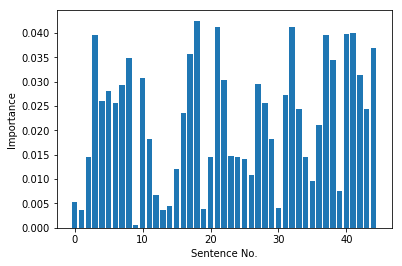

In [11]:
# Plotted the bar graph to see the importance of each sentence
plt.bar([item[0] for item in sorted(enumerate(sentence_ranks))], sentence_ranks.T[0])
plt.xlabel("Sentence No.")
plt.ylabel("Importance")
plt.show()

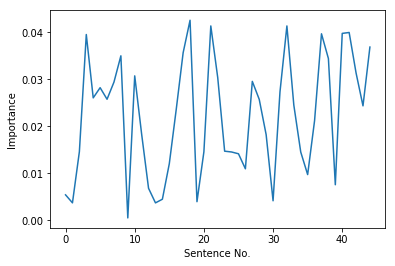

In [12]:
# plotted the graph
plt.plot([item[0] for item in sorted(enumerate(sentence_ranks))], sentence_ranks)
plt.xlabel("Sentence No.")
plt.ylabel("Importance")
plt.show()

In [13]:
# load model and vectors
model = joblib.load('C:/Users/Vijay/Desktop/code/code/model.pkl')
vect = joblib.load('C:/Users/Vijay/Desktop/code/code/vectorizer.pkl')

 # function to accept raw string and to provide news type(class)
def check_news_type(news_article): 
    news_article = [' '.join([Word(word).lemmatize() for word in clean_str(news_article).split()])]
    features = vect.transform(news_article)
    return str(model.predict(features)[0])

In [14]:
# article_name = Article(url, language="en")
# article_name.download()
# article_name.parse()
p = article_name.text

In [15]:
# created the variable for the number of sentences we want for the summary
SUMMARY_SIZE = 5
print("-------------TOPIC------------------")
# Printing the category of the News Article using the classification Algorithm
print(check_news_type(p))
print("-------------SUMMARY----------------")
selected_sentences = sorted(ranked_sentence_indexes[:SUMMARY_SIZE])
summary = itemgetter(*selected_sentences)(sentences)
# Printing the top 5 Sentences on the basis of TextRank Algorithm
for i in range(len(summary)):
    print(str(i+1)+". "+''.join(summary[i].splitlines()).strip())

-------------TOPIC------------------
business
-------------SUMMARY----------------
1. Honda's Swindon plant produces both VTEC turbo petrol engines and diesel i-DTEC engines
2. And Toyota and Jaguar Land Rover have expressed concern about the risk of a potential no-deal Brexit in recent months
3. "Were there clues this was coming?Only last autumn, Honda said it was committed to UK-based production regardless of the outcome of Brexit negotiations
4. In 1989, the operations expanded to producing engines
5. Three years later, a car plant was added, which began producing the Honda Accord
